# Predicting Shark Attacks - WORK IN PROGRESS

This project will attempt to build a model that will be able to predict shark attacks based on various oceanic, astrological, meteorological, and marine life factors. 

## Data

The data used for modeling was obtained from [Kaggle](https://www.kaggle.com/dingo1694/shark-attack) and contains values collected mainly from North and South Carolina Beaches. It is important to note that 61% of the location data is Null, while the remaining 39% indicate the data was collected from the Carolinas. Because this dataset is small, this project worked under the assumption that all data was collected from this region to maintain as much data as possible.

The [Global Shark Attack File](https://www.sharkattackfile.net/incidentlog.htm) was obtained from the [Shark Research Institute](https://www.sharks.org/), an organization dedicated to "inform[ing] and guid[ing] governing bodies and society at large to conservation policies that ensure the sustainability of all shark species." This file contains roughly 4600 reported shark attacks dating back to the mid-1800's. While it does not contain the same oceanic, astrological, meteorological, or marine life measures, it does include location data, activity of the victim, and whether or not the shark was provoked. This data was used to help inform data analysis and model development.

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# YOLO
import warnings
warnings.filterwarnings('ignore')

**Encountered a UTF-8 ecoding error. The suggestions in this discussion resolved the issue:** https://stackoverflow.com/questions/18171739/unicodedecodeerror-when-reading-csv-file-in-pandas-with-python

In [2]:
data = pd.read_csv('sharks.csv', encoding='ISO-8859-1')
print(data.shape)
data.head()

(186, 72)


,X.2,X.1,X,Id,Date,ID,TurtleExactCountSC,turtleexactdiscretizeSC,TurtleExactCountNC,TurtleExactCombined,...,StationPressure_minmax,WindSpeed_minmax,Salinity_minmax,Turbidity_minmax,Dissolved02_minmax,WaterTemp_minmax,Turtle_minmax,Crablandings_minmax,turbidity_kmeans_binning,turbidty_domain
0,1,1,1,4,5/4/09,25,0.0,Low,0.0,0,...,0.578947,0.333333,0.636021,0.032566,0.741354,0.576733,0.000000,0.933566,Low,Low
1,2,2,2,5,5/5/09,33,0.0,Low,0.0,0,...,0.649123,0.202614,0.552312,0.037936,0.675088,0.477558,0.000000,0.114510,Low,Medium
2,3,3,3,7,5/7/09,49,1.0,Low,0.0,0,...,0.508772,0.405229,0.496314,0.027615,0.703665,0.498185,0.000000,0.925699,Low,Low
3,4,4,4,8,5/8/09,57,0.0,Low,0.0,0,...,0.508772,0.267974,0.579198,0.020119,0.788776,0.575743,0.000000,0.296329,Low,Low
4,5,5,5,11,5/11/09,81,2.0,Low,0.0,1,...,0.614035,0.385621,0.597837,0.066004,0.822323,0.627393,0.004785,0.994755,Low,Medium


In [78]:
data.describe()

,X.2,X.1,X,Id,ID,TurtleExactCountSC,TurtleExactCountNC,TurtleExactCombined,TurtleAttackActivity,Precipitation_Value,...,Dissolved02_Normalised,Precipitation_minmax,StationPressure_minmax,WindSpeed_minmax,Salinity_minmax,Turbidity_minmax,Dissolved02_minmax,WaterTemp_minmax,Turtle_minmax,Crablandings_minmax
count,186.000000,186.000000,186.000000,186.000000,186.000000,151.000000,149.000000,186.000000,72.000000,182.000000,...,1.860000e+02,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000
mean,93.500000,93.500000,93.500000,414.188172,564.478495,40.920530,13.328859,32.596774,1.902778,0.133187,...,-2.688170e-11,0.039263,0.585550,0.345562,0.711591,0.055815,0.602410,0.738559,0.155965,0.517139
std,53.837719,53.837719,53.837719,362.030881,314.838856,48.536519,15.538724,41.343829,3.849857,0.392210,...,1.000000e+00,0.111143,0.193562,0.205506,0.164330,0.109588,0.154746,0.174951,0.197817,0.304463
min,1.000000,1.000000,1.000000,4.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-3.892896e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.250000,47.250000,47.250000,145.000000,337.500000,0.000000,0.000000,1.000000,0.000000,0.000000,...,-2.537028e-01,0.000000,0.473684,0.196078,0.601342,0.012498,0.563150,0.646205,0.004785,0.244974
50%,93.500000,93.500000,93.500000,277.500000,510.000000,23.000000,7.000000,19.500000,0.000000,0.000000,...,1.799387e-01,0.000000,0.596491,0.313725,0.733726,0.020990,0.630255,0.768977,0.093301,0.503497
75%,139.750000,139.750000,139.750000,633.750000,851.750000,67.500000,22.000000,46.750000,1.250000,0.057500,...,5.379092e-01,0.020000,0.719298,0.450980,0.830963,0.050026,0.685649,0.874794,0.223684,0.793706
max,186.000000,186.000000,186.000000,1167.000000,1148.000000,209.000000,54.000000,209.000000,19.000000,3.500000,...,2.569308e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186 entries, 0 to 185
Data columns (total 72 columns):
X.2                                186 non-null int64
X.1                                186 non-null int64
X                                  186 non-null int64
Id                                 186 non-null int64
Date                               186 non-null object
ID                                 186 non-null int64
TurtleExactCountSC                 151 non-null float64
turtleexactdiscretizeSC            151 non-null object
TurtleExactCountNC                 149 non-null float64
TurtleExactCombined                186 non-null int64
TurtleexactdiscretizeNC            149 non-null object
TurtleAttackActivity               72 non-null float64
TurtleAttackActivityDiscretized    72 non-null object
Area                               72 non-null object
Location                           72 non-null object
Time                               60 non-null object
Species                

In [11]:
# Check for null values
data.isna().sum()

X.2                                  0
X.1                                  0
X                                    0
Id                                   0
Date                                 0
ID                                   0
TurtleExactCountSC                  35
turtleexactdiscretizeSC             35
TurtleExactCountNC                  37
TurtleExactCombined                  0
TurtleexactdiscretizeNC             37
TurtleAttackActivity               114
TurtleAttackActivityDiscretized    114
Area                               114
Location                           114
Time                               126
Species                            134
Attack                               0
Timeofattack                       114
Beach                              114
County                             114
MoonPhaseExtended                    0
MoonPhase                            0
Precipitation_Value                  4
StationPressure                      4
WindSpeed                

In [3]:
# Drop columns 1-17 as they contain significant null values or are redundant 
drop_cols = []
for name in data.columns[1:17]:
    drop_cols.append(name)

data1 = data.drop(drop_cols, axis=1)
data1.head()

['X.1',
 'X',
 'Id',
 'Date',
 'ID',
 'TurtleExactCountSC',
 'turtleexactdiscretizeSC',
 'TurtleExactCountNC',
 'TurtleExactCombined',
 'TurtleexactdiscretizeNC',
 'TurtleAttackActivity',
 'TurtleAttackActivityDiscretized',
 'Area',
 'Location',
 'Time',
 'Species']

In [37]:
# check results
data1.isna().sum()

Attack                          0
Timeofattack                  114
Beach                         114
County                        114
MoonPhaseExtended               0
MoonPhase                       0
Precipitation_Value             4
StationPressure                 4
WindSpeed                       4
Salinity                        4
Turbidity                       4
Temperature                     4
DissovedO2                      4
PrecipitationValueMod           0
StationPressureMod              0
WindSpeedMod                    0
SalinityMod                     0
TurbidityMod                    0
TemperatureMod                  0
DissovedO2Mod                   0
DissolvedO2discretize           0
salinitydiscretize              0
turbiditydiscretize             0
temperaturediscretize           0
precipitationdiscretize         0
pressurediscretize              0
windspeeddiscretize             0
prepmovingaverage               0
precipitationmvadiscretize      0
CrabLandings  

In [5]:
# Drop additional columns that contain significant number of null values
data2 = data1.drop(['Timeofattack', 'Beach', 'County'], axis=1)
data2.head()

,X.2,Attack,MoonPhaseExtended,MoonPhase,Precipitation_Value,StationPressure,WindSpeed,Salinity,Turbidity,Temperature,...,StationPressure_minmax,WindSpeed_minmax,Salinity_minmax,Turbidity_minmax,Dissolved02_minmax,WaterTemp_minmax,Turtle_minmax,Crablandings_minmax,turbidity_kmeans_binning,turbidty_domain
0,1,No,First quarter,First quarter,0.00,29.96,6.4,24.215556,23.422222,26.008889,...,0.578947,0.333333,0.636021,0.032566,0.741354,0.576733,0.000000,0.933566,Low,Low
1,2,No,Waxing gibbous,First quarter,0.19,30.00,4.4,21.960000,26.844444,24.673333,...,0.649123,0.202614,0.552312,0.037936,0.675088,0.477558,0.000000,0.114510,Low,Medium
2,3,No,Full,Waxing gibbous,0.00,29.92,7.5,20.451111,20.266667,24.951111,...,0.508772,0.405229,0.496314,0.027615,0.703665,0.498185,0.000000,0.925699,Low,Low
3,4,No,Full,Waxing gibbous,0.00,29.92,5.4,22.684444,15.488889,25.995556,...,0.508772,0.267974,0.579198,0.020119,0.788776,0.575743,0.000000,0.296329,Low,Low
4,5,No,Full,Full,0.00,29.98,7.2,23.186667,44.733333,26.691111,...,0.614035,0.385621,0.597837,0.066004,0.822323,0.627393,0.004785,0.994755,Low,Medium


In [39]:
# check results
data2.isna().sum()

Attack                        0
MoonPhaseExtended             0
MoonPhase                     0
Precipitation_Value           4
StationPressure               4
WindSpeed                     4
Salinity                      4
Turbidity                     4
Temperature                   4
DissovedO2                    4
PrecipitationValueMod         0
StationPressureMod            0
WindSpeedMod                  0
SalinityMod                   0
TurbidityMod                  0
TemperatureMod                0
DissovedO2Mod                 0
DissolvedO2discretize         0
salinitydiscretize            0
turbiditydiscretize           0
temperaturediscretize         0
precipitationdiscretize       0
pressurediscretize            0
windspeeddiscretize           0
prepmovingaverage             0
precipitationmvadiscretize    0
CrabLandings                  0
CrabLandingsnormalised        0
CrabLandingsDisc              0
Degree                        0
Direction                     0
MoonPhas

In [6]:
# Drop rows containing null values
data_fin = data2.dropna(axis=0)
data_fin.head()

,X.2,Attack,MoonPhaseExtended,MoonPhase,Precipitation_Value,StationPressure,WindSpeed,Salinity,Turbidity,Temperature,...,StationPressure_minmax,WindSpeed_minmax,Salinity_minmax,Turbidity_minmax,Dissolved02_minmax,WaterTemp_minmax,Turtle_minmax,Crablandings_minmax,turbidity_kmeans_binning,turbidty_domain
0,1,No,First quarter,First quarter,0.00,29.96,6.4,24.215556,23.422222,26.008889,...,0.578947,0.333333,0.636021,0.032566,0.741354,0.576733,0.000000,0.933566,Low,Low
1,2,No,Waxing gibbous,First quarter,0.19,30.00,4.4,21.960000,26.844444,24.673333,...,0.649123,0.202614,0.552312,0.037936,0.675088,0.477558,0.000000,0.114510,Low,Medium
2,3,No,Full,Waxing gibbous,0.00,29.92,7.5,20.451111,20.266667,24.951111,...,0.508772,0.405229,0.496314,0.027615,0.703665,0.498185,0.000000,0.925699,Low,Low
3,4,No,Full,Waxing gibbous,0.00,29.92,5.4,22.684444,15.488889,25.995556,...,0.508772,0.267974,0.579198,0.020119,0.788776,0.575743,0.000000,0.296329,Low,Low
4,5,No,Full,Full,0.00,29.98,7.2,23.186667,44.733333,26.691111,...,0.614035,0.385621,0.597837,0.066004,0.822323,0.627393,0.004785,0.994755,Low,Medium


In [41]:
# Check results
data_fin.isna().sum()

Attack                        0
MoonPhaseExtended             0
MoonPhase                     0
Precipitation_Value           0
StationPressure               0
WindSpeed                     0
Salinity                      0
Turbidity                     0
Temperature                   0
DissovedO2                    0
PrecipitationValueMod         0
StationPressureMod            0
WindSpeedMod                  0
SalinityMod                   0
TurbidityMod                  0
TemperatureMod                0
DissovedO2Mod                 0
DissolvedO2discretize         0
salinitydiscretize            0
turbiditydiscretize           0
temperaturediscretize         0
precipitationdiscretize       0
pressurediscretize            0
windspeeddiscretize           0
prepmovingaverage             0
precipitationmvadiscretize    0
CrabLandings                  0
CrabLandingsnormalised        0
CrabLandingsDisc              0
Degree                        0
Direction                     0
MoonPhas

Many of the columns have names that suggest they underwent some sort of mathematical transformation. The source of this data does not indicate who performed these transformations or how they were transformed. For this reason, the data contained in these columns will be discarded.

In [7]:
data_raw = data_fin[['Attack','MoonPhase','Precipitation_Value','StationPressure','WindSpeed',
                     'Salinity','Turbidity','Temperature','DissovedO2', 'CrabLandings', 'Degree', 'Direction']]
print(data_raw.shape)
data_raw.head()

(182, 15)


,X.2,Attack,MoonPhaseExtended,MoonPhase,Precipitation_Value,StationPressure,WindSpeed,Salinity,Turbidity,Temperature,DissovedO2,CrabLandings,Degree,Direction,changetemp
0,1,No,First quarter,First quarter,0.00,29.96,6.4,24.215556,23.422222,26.008889,82.555556,1070,223.355556,SW,EQ
1,2,No,Waxing gibbous,First quarter,0.19,30.00,4.4,21.960000,26.844444,24.673333,75.444444,133,206.222222,SSW,EQ
2,3,No,Full,Waxing gibbous,0.00,29.92,7.5,20.451111,20.266667,24.951111,78.511111,1061,212.111111,SSW,EQ
3,4,No,Full,Waxing gibbous,0.00,29.92,5.4,22.684444,15.488889,25.995556,87.644444,341,222.977778,SW,EQ
4,5,No,Full,Full,0.00,29.98,7.2,23.186667,44.733333,26.691111,91.244444,1140,34.022222,NE,EQ


In [8]:
data_raw.loc[(data_raw.Attack == 'No'), 'Attack'] = 0
data_raw.loc[(data_raw.Attack == 'Yes'), 'Attack'] = 1
print(data_raw.Attack.value_counts())
data_raw.head()

0    114
1     68
Name: Attack, dtype: int64


/Users/kpokrass_pro/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,X.2,Attack,MoonPhaseExtended,MoonPhase,Precipitation_Value,StationPressure,WindSpeed,Salinity,Turbidity,Temperature,DissovedO2,CrabLandings,Degree,Direction,changetemp
0,1,0,First quarter,First quarter,0.00,29.96,6.4,24.215556,23.422222,26.008889,82.555556,1070,223.355556,SW,EQ
1,2,0,Waxing gibbous,First quarter,0.19,30.00,4.4,21.960000,26.844444,24.673333,75.444444,133,206.222222,SSW,EQ
2,3,0,Full,Waxing gibbous,0.00,29.92,7.5,20.451111,20.266667,24.951111,78.511111,1061,212.111111,SSW,EQ
3,4,0,Full,Waxing gibbous,0.00,29.92,5.4,22.684444,15.488889,25.995556,87.644444,341,222.977778,SW,EQ
4,5,0,Full,Full,0.00,29.98,7.2,23.186667,44.733333,26.691111,91.244444,1140,34.022222,NE,EQ


# Exploratory Data Analysis

/Users/kpokrass_pro/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/kpokrass_pro/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/Users/kpokrass_pro/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


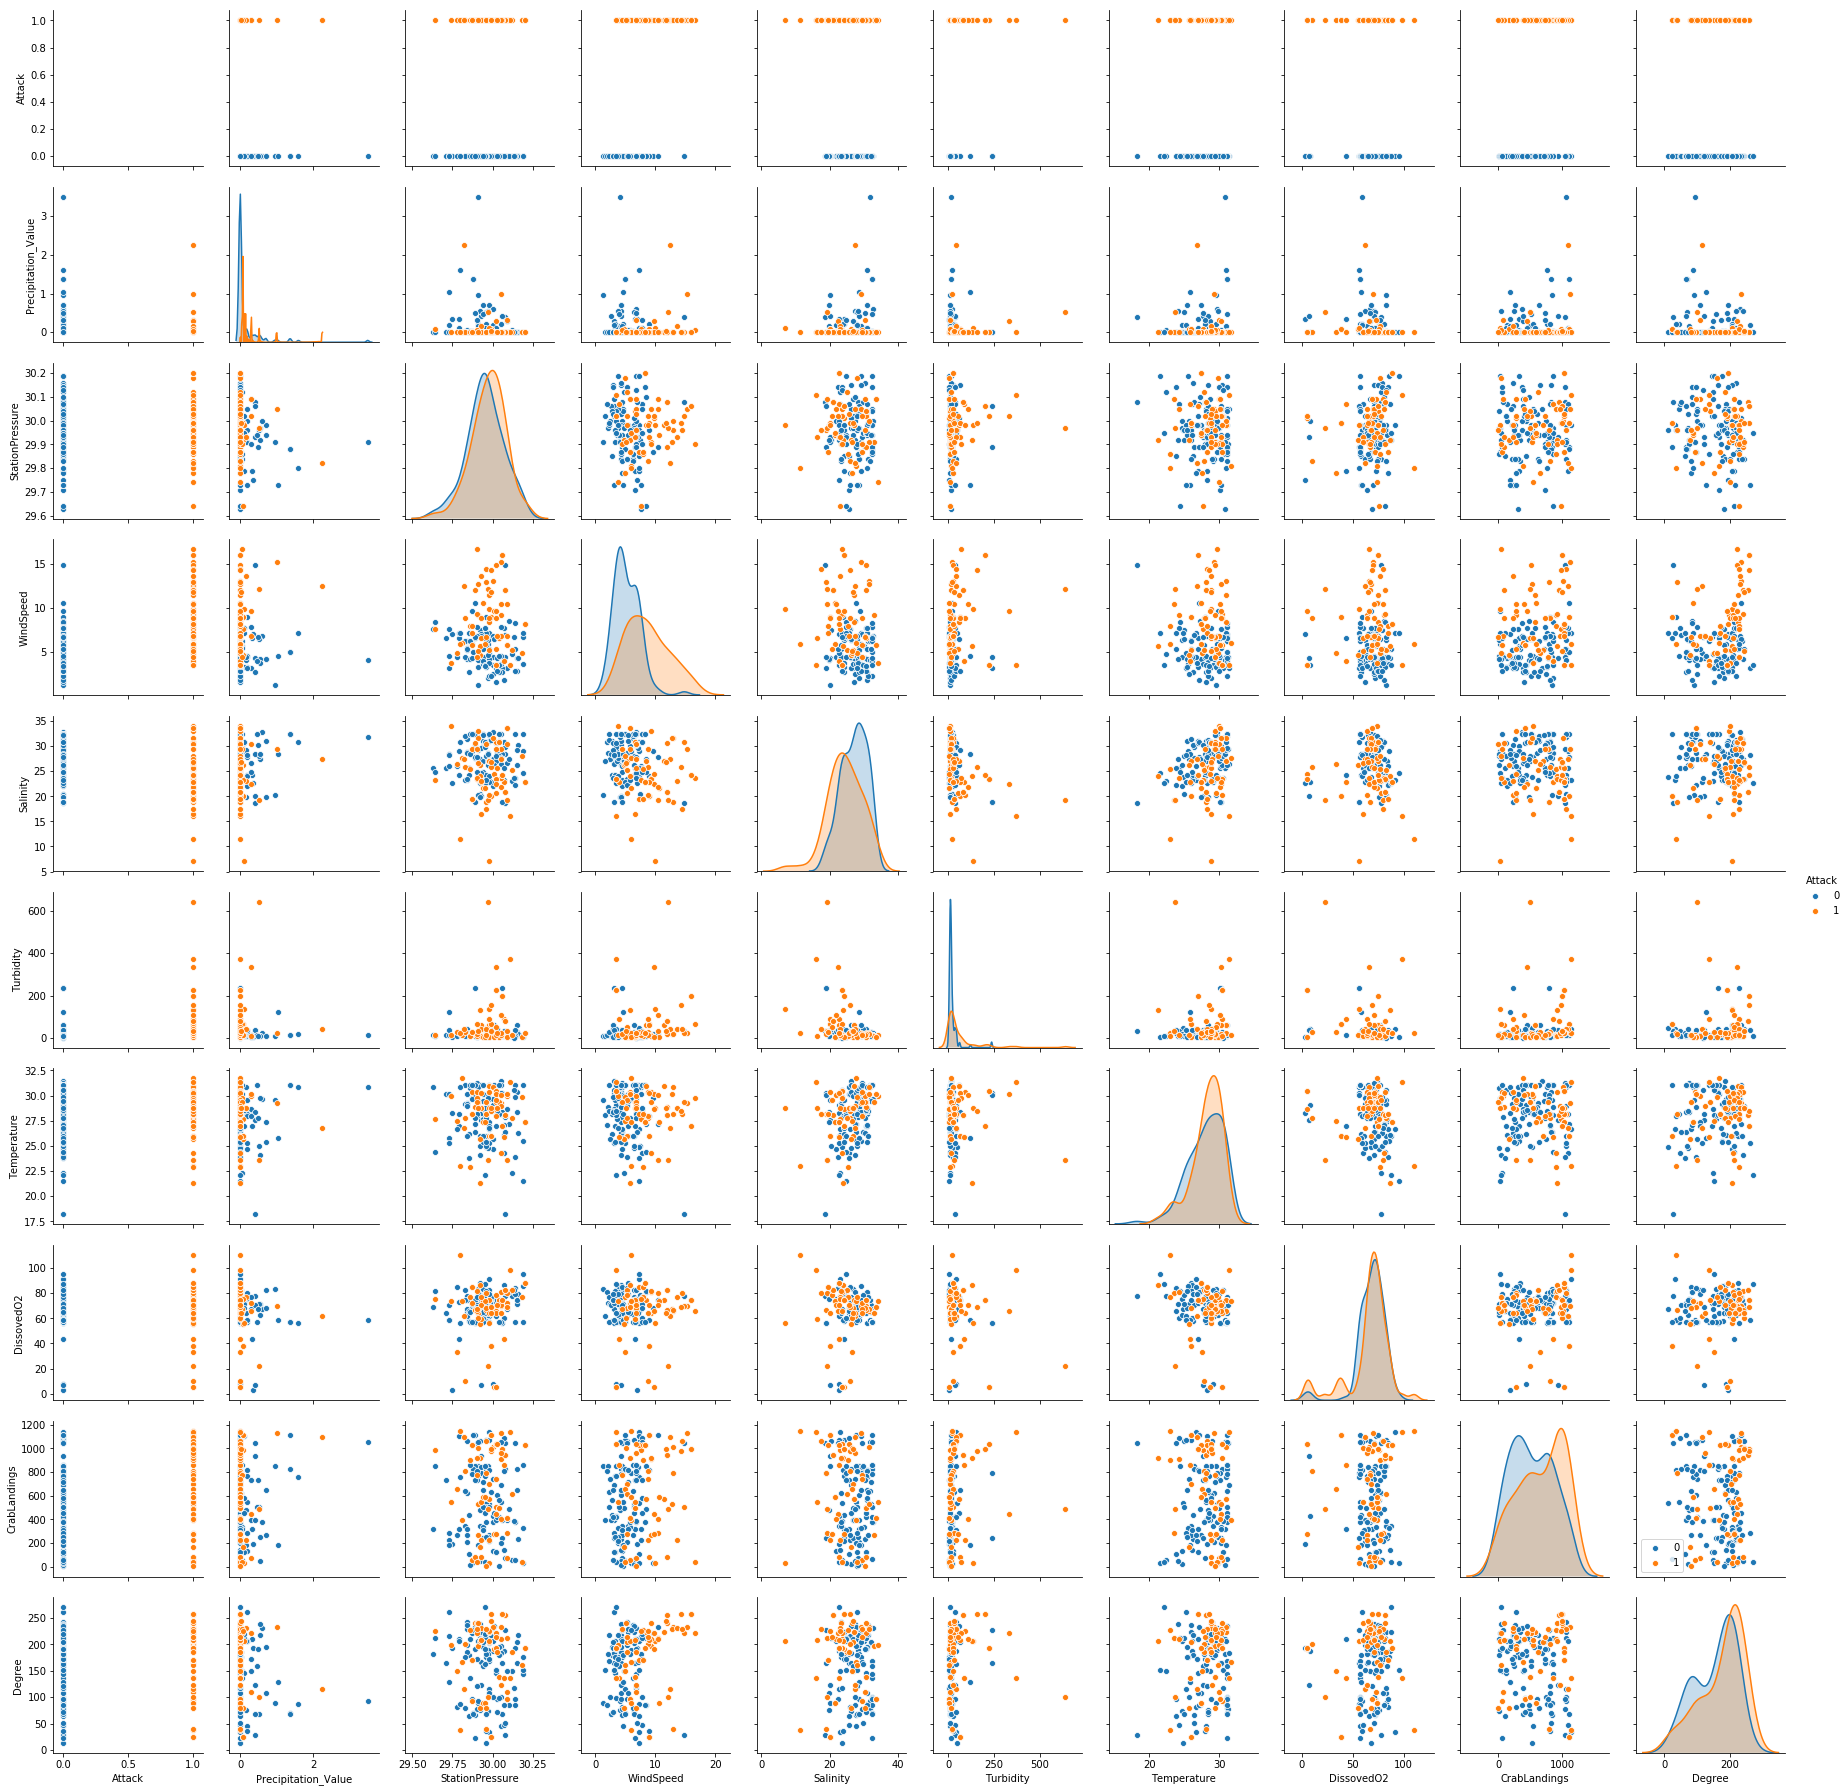

In [26]:
# Look for correlation with continuous variables
sns.pairplot(data_raw, hue='Attack')
plt.legend()
plt.show()

**Analysis:** Looking at the distribution plots that run along the diagonal of the scatterplot matrix, it does appear that shark attacks happen more frequently when wind speed and number of crab landings are higher and when salinity is lower. Additionally there doesn't appear to be strong evidence of correlation between the features (multicolinearity), but this will examined further with a heatmap in the next cell.

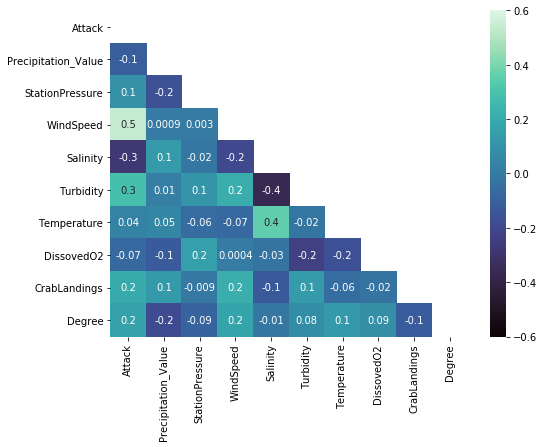

In [36]:
mask = np.zeros_like(data_raw.corr())
mask[np.triu_indices_from(mask)] = True

fig = plt.figure(figsize=(8,6))
sns.heatmap(data_raw.corr(), vmin=-.6, vmax=.6, mask=mask, cmap='mako', annot=True, fmt='.1g')
plt.show()

**Analysis:** Several features display moderate levels of correlation with the frequency of shark attacks. Wind speed shows the strongest positive correlation (0.5) with attacks, while salinity shows the strongest negative correlation (-0.3). These findings are in line with the conclusions drawn from the pairplot above. While it was difficult to determine from the pairplot, turbidity also shows a moderate positive correlation (0.3) with attacks when analyzed using this heatmap. Additionally, there does not appear to be strong evidence of multicolinearity as the strongest within-feature correlations are -0.4 (turbidity-salinity) and 0.4 (temperature-salinity). No action needs to be taken at this time to address multicolinearity as these interactions are moderate at best.

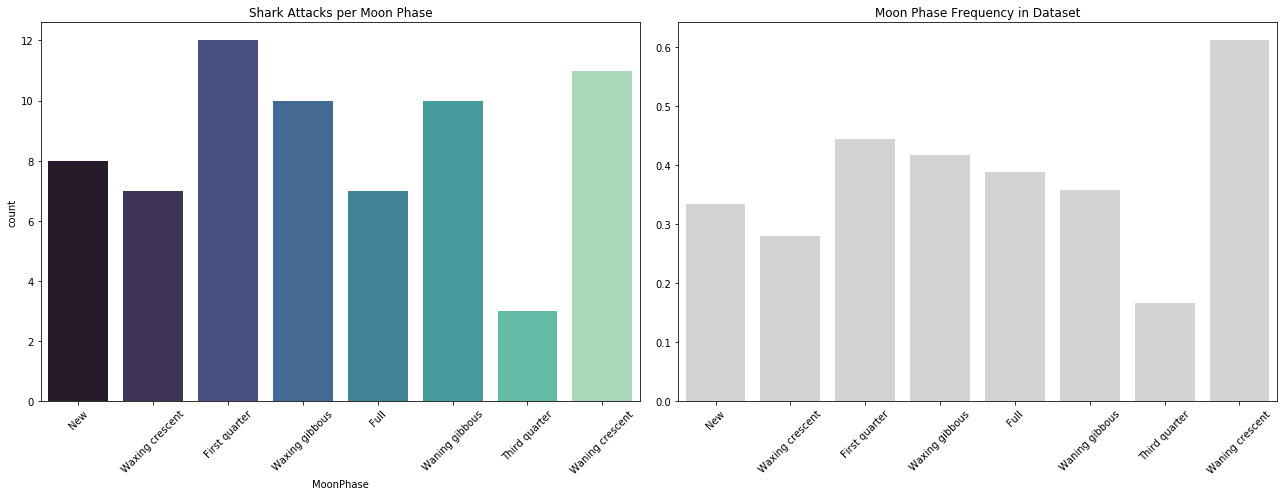

In [43]:
# Look for trend in categorical variable - MoonPhase
attacks = data_raw[data_raw.Attack == 1]

moonphase = ['New', 'Waxing crescent', 'First quarter', 'Waxing gibbous', 'Full', 'Waning gibbous', 'Third quarter', 
            'Waning crescent']

moon_freq = []
for phase in moonphase:
    total_phase = len(data_raw[data_raw.MoonPhase == phase])
    attack_phase = len(attacks[attacks.MoonPhase == phase])
    if total_phase > 0 and attack_phase > 0:
        moon_freq.append((attack_phase / total_phase))
    else:
        moon_freq.append(0)
        
moon_freq_df = pd.DataFrame(np.array(moon_freq)).T
moon_freq_df.columns = moonphase

fig, ax = plt.subplots(1,2, figsize=(18,7))
sns.countplot(x='MoonPhase', data=attacks, order=moonphase, palette='mako', ax=ax[0])
ax[0].set_title('Shark Attacks per Moon Phase')
ax[0].xaxis.set_tick_params(rotation=45)
sns.barplot(data=moon_freq_df, order=moonphase, color='lightgrey', ax=ax[1])
ax[1].set_title('Moon Phase Frequency in Dataset')
ax[1].xaxis.set_tick_params(rotation=45)

# sns.countplot(x='MoonPhase', data=attacks, palette='mako', ax=ax[1,0])
# ax[1,0].set_title('Shark Attacks per Moon Phase')
# ax[1,0].xaxis.set_tick_params(rotation=45)
# sns.countplot(x='MoonPhase', data=data_raw, color='lightgrey', ax=ax[1,1])
# ax[1,1].set_title('Moon Phase Frequency in Dataset')
# ax[1,1].xaxis.set_tick_params(rotation=45)

plt.tight_layout()

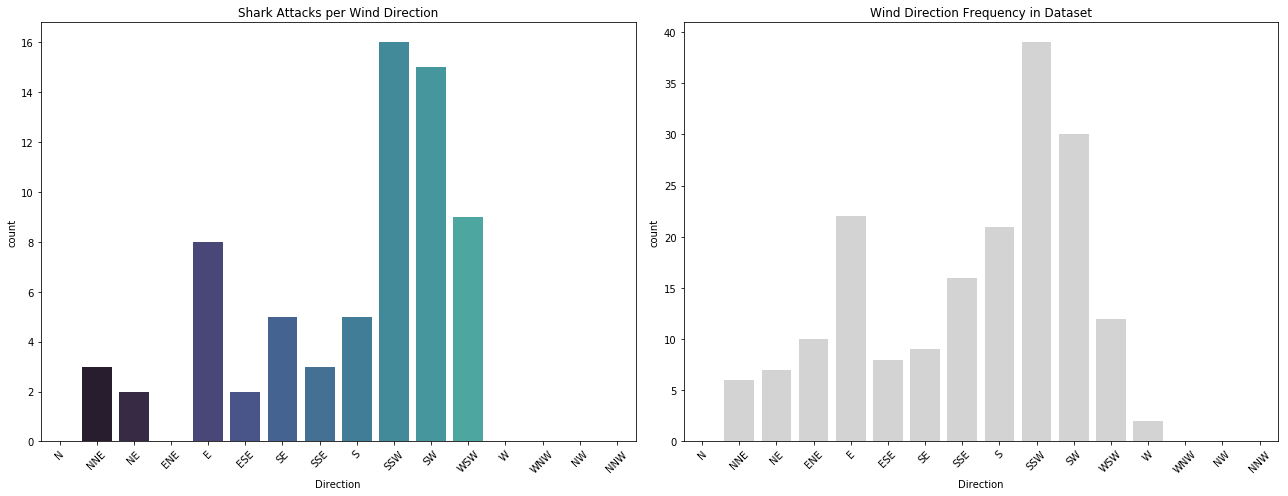

In [47]:
# Look for trend in categorical variable - Wind Direction

directions = ['N', 'NNE', 'NE', 'ENE', 'E', 'ESE', 'SE', 'SSE', 'S', 'SSW', 'SW', 'WSW', 'W', 'WNW', 'NW', 'NNW']

wind_freq = []
for wind in directions:
    total_wind = len(data_raw[data_raw.Direction == wind])
    attack_wind = len(attacks[attacks.Direction == wind])
    if total_wind > 0 and attack_wind > 0:
        wind_freq.append((attack_wind / total_wind))
    else:
        wind_freq.append(0)
        
wind_freq_df = pd.DataFrame(np.array(wind_freq)).T
wind_freq_df.columns = directions

fig, ax = plt.subplots(1,2, figsize=(18,7))
sns.countplot(x='Direction', data=attacks, order=directions, palette='mako', ax=ax[0])
ax[0].set_title('Shark Attacks per Wind Direction')
ax[0].xaxis.set_tick_params(rotation=45)
sns.countplot(x='Direction', data=data_raw, order=directions, color='lightgrey', ax=ax[1])
# sns.barplot(data=wind_freq_df, order=directions, color='lightgrey', ax=ax[1])
ax[1].set_title('Wind Direction Frequency in Dataset')
ax[1].xaxis.set_tick_params(rotation=45)

plt.tight_layout()

In [48]:
y = data_raw.Attack
x1 = data_raw.drop(['Attack'], axis=1)
x2 = data_raw.drop(['Attack', 'MoonPhase', 'Direction'], axis=1)

In [49]:
from sklearn.preprocessing import LabelEncoder

In [50]:
x1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 182 entries, 0 to 181
Data columns (total 11 columns):
MoonPhase              182 non-null object
Precipitation_Value    182 non-null float64
StationPressure        182 non-null float64
WindSpeed              182 non-null float64
Salinity               182 non-null float64
Turbidity              182 non-null float64
Temperature            182 non-null float64
DissovedO2             182 non-null float64
CrabLandings           182 non-null int64
Degree                 182 non-null float64
Direction              182 non-null object
dtypes: float64(8), int64(1), object(2)
memory usage: 22.1+ KB


In [51]:
x2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 182 entries, 0 to 181
Data columns (total 9 columns):
Precipitation_Value    182 non-null float64
StationPressure        182 non-null float64
WindSpeed              182 non-null float64
Salinity               182 non-null float64
Turbidity              182 non-null float64
Temperature            182 non-null float64
DissovedO2             182 non-null float64
CrabLandings           182 non-null int64
Degree                 182 non-null float64
dtypes: float64(8), int64(1)
memory usage: 19.2 KB


In [74]:
import featuretools as ft

In [75]:
x2.head()

,Precipitation_Value,StationPressure,WindSpeed,Salinity,Turbidity,Temperature,DissovedO2
0,0.00,29.96,6.4,24.215556,23.422222,26.008889,82.555556
1,0.19,30.00,4.4,21.960000,26.844444,24.673333,75.444444
2,0.00,29.92,7.5,20.451111,20.266667,24.951111,78.511111
3,0.00,29.92,5.4,22.684444,15.488889,25.995556,87.644444
4,0.00,29.98,7.2,23.186667,44.733333,26.691111,91.244444


In [76]:
x2.describe()

,Precipitation_Value,StationPressure,WindSpeed,Salinity,Turbidity,Temperature,DissovedO2
count,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000,182.000000
mean,0.133187,29.962308,6.551648,26.199711,38.295837,28.167618,67.678997
std,0.392210,0.111098,3.169533,4.462372,70.610488,2.377764,16.786865
min,0.000000,29.630000,1.300000,7.077778,2.666667,18.242222,3.000000
25%,0.000000,29.900000,4.300000,23.229444,10.577778,26.837778,62.642248
50%,0.000000,29.965000,5.900000,26.625556,15.865278,28.471111,70.800000
75%,0.057500,30.040000,7.875000,29.510000,31.638889,30.073889,76.633333
max,3.500000,30.200000,16.600000,34.023077,640.000000,31.708889,110.311111


In [111]:
ft_test = data_raw.copy()
ft_test.head()

,X.2,Attack,MoonPhaseExtended,MoonPhase,Precipitation_Value,StationPressure,WindSpeed,Salinity,Turbidity,Temperature,DissovedO2
0,1,No,First quarter,First quarter,0.00,29.96,6.4,24.215556,23.422222,26.008889,82.555556
1,2,No,Waxing gibbous,First quarter,0.19,30.00,4.4,21.960000,26.844444,24.673333,75.444444
2,3,No,Full,Waxing gibbous,0.00,29.92,7.5,20.451111,20.266667,24.951111,78.511111
3,4,No,Full,Waxing gibbous,0.00,29.92,5.4,22.684444,15.488889,25.995556,87.644444
4,5,No,Full,Full,0.00,29.98,7.2,23.186667,44.733333,26.691111,91.244444


In [112]:
ft_test.loc[(ft_test.Attack == 'No'), 'Attack'] = 0
ft_test.loc[(ft_test.Attack == 'Yes'), 'Attack'] = 1
print(ft_test.Attack.unique())
ft_test.head()

[0 1]


,X.2,Attack,MoonPhaseExtended,MoonPhase,Precipitation_Value,StationPressure,WindSpeed,Salinity,Turbidity,Temperature,DissovedO2
0,1,0,First quarter,First quarter,0.00,29.96,6.4,24.215556,23.422222,26.008889,82.555556
1,2,0,Waxing gibbous,First quarter,0.19,30.00,4.4,21.960000,26.844444,24.673333,75.444444
2,3,0,Full,Waxing gibbous,0.00,29.92,7.5,20.451111,20.266667,24.951111,78.511111
3,4,0,Full,Waxing gibbous,0.00,29.92,5.4,22.684444,15.488889,25.995556,87.644444
4,5,0,Full,Full,0.00,29.98,7.2,23.186667,44.733333,26.691111,91.244444


In [113]:
target = ft_test.Attack

In [114]:
ft_test = ft_test.drop(['Attack', 'MoonPhase', 'MoonPhaseExtended'], axis=1)
ft_test.head()

,X.2,Precipitation_Value,StationPressure,WindSpeed,Salinity,Turbidity,Temperature,DissovedO2
0,1,0.00,29.96,6.4,24.215556,23.422222,26.008889,82.555556
1,2,0.19,30.00,4.4,21.960000,26.844444,24.673333,75.444444
2,3,0.00,29.92,7.5,20.451111,20.266667,24.951111,78.511111
3,4,0.00,29.92,5.4,22.684444,15.488889,25.995556,87.644444
4,5,0.00,29.98,7.2,23.186667,44.733333,26.691111,91.244444


In [115]:
es = ft.EntitySet(id = 'test1')
es.entity_from_dataframe(entity_id = 'raw1', 
                         dataframe = ft_test, 
                         index = 'X.2')
es.entity_from_dataframe(entity_id = 'raw2', 
                         dataframe = ft_test, 
                         index = 'X.2')

Entityset: test1
  Entities:
    raw1 [Rows: 182, Columns: 8]
    raw2 [Rows: 182, Columns: 8]
  Relationships:
    No relationships

In [116]:
# Create the relationships
relate = ft.Relationship(es['raw1']['X.2'], es['raw2']['X.2'])
es.add_relationship(relate)

es

Entityset: test1
  Entities:
    raw1 [Rows: 182, Columns: 8]
    raw2 [Rows: 182, Columns: 8]
  Relationships:
    raw2.X.2 -> raw1.X.2

In [124]:
# Deep Feature Synthesis
feature_matrix, feature_names = ft.dfs(entityset=es,
                                       target_entity='raw1',
                                       max_depth = 3, 
                                       verbose = 1, 
                                       n_jobs = -1)

Built 49 features
EntitySet scattered to workers in 1.574 seconds
Elapsed: 00:00 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 11/11 chunks


In [125]:
all_features = [str(x.get_name()) for x in feature_names]
feature_matrix.head()

,Precipitation_Value,StationPressure,WindSpeed,Salinity,Turbidity,Temperature,DissovedO2,SUM(raw2.Precipitation_Value),SUM(raw2.StationPressure),SUM(raw2.WindSpeed),...,MIN(raw2.Turbidity),MIN(raw2.Temperature),MIN(raw2.DissovedO2),MEAN(raw2.Precipitation_Value),MEAN(raw2.StationPressure),MEAN(raw2.WindSpeed),MEAN(raw2.Salinity),MEAN(raw2.Turbidity),MEAN(raw2.Temperature),MEAN(raw2.DissovedO2)
X.2,,,,,,,,,,,,,,,,,,,,,
1,0.00,29.96,6.4,24.215556,23.422222,26.008889,82.555556,0.00,29.96,6.4,...,23.422222,26.008889,82.555556,0.00,29.96,6.4,24.215556,23.422222,26.008889,82.555556
2,0.19,30.00,4.4,21.960000,26.844444,24.673333,75.444444,0.19,30.00,4.4,...,26.844444,24.673333,75.444444,0.19,30.00,4.4,21.960000,26.844444,24.673333,75.444444
3,0.00,29.92,7.5,20.451111,20.266667,24.951111,78.511111,0.00,29.92,7.5,...,20.266667,24.951111,78.511111,0.00,29.92,7.5,20.451111,20.266667,24.951111,78.511111
4,0.00,29.92,5.4,22.684444,15.488889,25.995556,87.644444,0.00,29.92,5.4,...,15.488889,25.995556,87.644444,0.00,29.92,5.4,22.684444,15.488889,25.995556,87.644444
5,0.00,29.98,7.2,23.186667,44.733333,26.691111,91.244444,0.00,29.98,7.2,...,44.733333,26.691111,91.244444,0.00,29.98,7.2,23.186667,44.733333,26.691111,91.244444


In [127]:
feature_matrix.isna().sum()

Precipitation_Value                 0
StationPressure                     0
WindSpeed                           0
Salinity                            0
Turbidity                           0
Temperature                         0
DissovedO2                          0
SUM(raw2.Precipitation_Value)       0
SUM(raw2.StationPressure)           0
SUM(raw2.WindSpeed)                 0
SUM(raw2.Salinity)                  0
SUM(raw2.Turbidity)                 0
SUM(raw2.Temperature)               0
SUM(raw2.DissovedO2)                0
STD(raw2.Precipitation_Value)     182
STD(raw2.StationPressure)         182
STD(raw2.WindSpeed)               182
STD(raw2.Salinity)                182
STD(raw2.Turbidity)               182
STD(raw2.Temperature)             182
STD(raw2.DissovedO2)              182
MAX(raw2.Precipitation_Value)       0
MAX(raw2.StationPressure)           0
MAX(raw2.WindSpeed)                 0
MAX(raw2.Salinity)                  0
MAX(raw2.Turbidity)                 0
MAX(raw2.Tem

In [128]:
feature_matrix = feature_matrix.dropna(axis=1)
feature_matrix.head()

,Precipitation_Value,StationPressure,WindSpeed,Salinity,Turbidity,Temperature,DissovedO2,SUM(raw2.Precipitation_Value),SUM(raw2.StationPressure),SUM(raw2.WindSpeed),...,MIN(raw2.Turbidity),MIN(raw2.Temperature),MIN(raw2.DissovedO2),MEAN(raw2.Precipitation_Value),MEAN(raw2.StationPressure),MEAN(raw2.WindSpeed),MEAN(raw2.Salinity),MEAN(raw2.Turbidity),MEAN(raw2.Temperature),MEAN(raw2.DissovedO2)
X.2,,,,,,,,,,,,,,,,,,,,,
1,0.00,29.96,6.4,24.215556,23.422222,26.008889,82.555556,0.00,29.96,6.4,...,23.422222,26.008889,82.555556,0.00,29.96,6.4,24.215556,23.422222,26.008889,82.555556
2,0.19,30.00,4.4,21.960000,26.844444,24.673333,75.444444,0.19,30.00,4.4,...,26.844444,24.673333,75.444444,0.19,30.00,4.4,21.960000,26.844444,24.673333,75.444444
3,0.00,29.92,7.5,20.451111,20.266667,24.951111,78.511111,0.00,29.92,7.5,...,20.266667,24.951111,78.511111,0.00,29.92,7.5,20.451111,20.266667,24.951111,78.511111
4,0.00,29.92,5.4,22.684444,15.488889,25.995556,87.644444,0.00,29.92,5.4,...,15.488889,25.995556,87.644444,0.00,29.92,5.4,22.684444,15.488889,25.995556,87.644444
5,0.00,29.98,7.2,23.186667,44.733333,26.691111,91.244444,0.00,29.98,7.2,...,44.733333,26.691111,91.244444,0.00,29.98,7.2,23.186667,44.733333,26.691111,91.244444


In [126]:
all_features

['Precipitation_Value',
 'StationPressure',
 'WindSpeed',
 'Salinity',
 'Turbidity',
 'Temperature',
 'DissovedO2',
 'SUM(raw2.Precipitation_Value)',
 'SUM(raw2.StationPressure)',
 'SUM(raw2.WindSpeed)',
 'SUM(raw2.Salinity)',
 'SUM(raw2.Turbidity)',
 'SUM(raw2.Temperature)',
 'SUM(raw2.DissovedO2)',
 'STD(raw2.Precipitation_Value)',
 'STD(raw2.StationPressure)',
 'STD(raw2.WindSpeed)',
 'STD(raw2.Salinity)',
 'STD(raw2.Turbidity)',
 'STD(raw2.Temperature)',
 'STD(raw2.DissovedO2)',
 'MAX(raw2.Precipitation_Value)',
 'MAX(raw2.StationPressure)',
 'MAX(raw2.WindSpeed)',
 'MAX(raw2.Salinity)',
 'MAX(raw2.Turbidity)',
 'MAX(raw2.Temperature)',
 'MAX(raw2.DissovedO2)',
 'SKEW(raw2.Precipitation_Value)',
 'SKEW(raw2.StationPressure)',
 'SKEW(raw2.WindSpeed)',
 'SKEW(raw2.Salinity)',
 'SKEW(raw2.Turbidity)',
 'SKEW(raw2.Temperature)',
 'SKEW(raw2.DissovedO2)',
 'MIN(raw2.Precipitation_Value)',
 'MIN(raw2.StationPressure)',
 'MIN(raw2.WindSpeed)',
 'MIN(raw2.Salinity)',
 'MIN(raw2.Turbidity)'

In [120]:
# Create correlation matrix
corr_matrix = feature_matrix.corr().abs()
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] >= 0.99)]

print('There are {} columns with >= 0.99 correlation.'.format(len(to_drop)))
to_drop

There are 28 columns with >= 0.99 correlation.


['SUM(raw2.Precipitation_Value)',
 'SUM(raw2.StationPressure)',
 'SUM(raw2.WindSpeed)',
 'SUM(raw2.Salinity)',
 'SUM(raw2.Turbidity)',
 'SUM(raw2.Temperature)',
 'SUM(raw2.DissovedO2)',
 'MAX(raw2.Precipitation_Value)',
 'MAX(raw2.StationPressure)',
 'MAX(raw2.WindSpeed)',
 'MAX(raw2.Salinity)',
 'MAX(raw2.Turbidity)',
 'MAX(raw2.Temperature)',
 'MAX(raw2.DissovedO2)',
 'MIN(raw2.Precipitation_Value)',
 'MIN(raw2.StationPressure)',
 'MIN(raw2.WindSpeed)',
 'MIN(raw2.Salinity)',
 'MIN(raw2.Turbidity)',
 'MIN(raw2.Temperature)',
 'MIN(raw2.DissovedO2)',
 'MEAN(raw2.Precipitation_Value)',
 'MEAN(raw2.StationPressure)',
 'MEAN(raw2.WindSpeed)',
 'MEAN(raw2.Salinity)',
 'MEAN(raw2.Turbidity)',
 'MEAN(raw2.Temperature)',
 'MEAN(raw2.DissovedO2)']

In [121]:
feature_matrix = feature_matrix[[x for x in feature_matrix if x not in to_drop]]

In [123]:
feature_matrix.isna().sum()

Precipitation_Value                 0
StationPressure                     0
WindSpeed                           0
Salinity                            0
Turbidity                           0
Temperature                         0
DissovedO2                          0
STD(raw2.Precipitation_Value)     182
STD(raw2.StationPressure)         182
STD(raw2.WindSpeed)               182
STD(raw2.Salinity)                182
STD(raw2.Turbidity)               182
STD(raw2.Temperature)             182
STD(raw2.DissovedO2)              182
SKEW(raw2.Precipitation_Value)    182
SKEW(raw2.StationPressure)        182
SKEW(raw2.WindSpeed)              182
SKEW(raw2.Salinity)               182
SKEW(raw2.Turbidity)              182
SKEW(raw2.Temperature)            182
SKEW(raw2.DissovedO2)             182
dtype: int64

In [130]:
es = ft.EntitySet(id = 'test2')
es.entity_from_dataframe(entity_id = 'raw', 
                         dataframe = ft_test, 
                         index = 'X.2')

Entityset: test2
  Entities:
    raw [Rows: 182, Columns: 8]
  Relationships:
    No relationships

In [131]:
es.normalize_entity(base_entity_id='raw', 
                    new_entity_id='raw_norm', 
                    index = 'X.2')
es

Entityset: test2
  Entities:
    raw [Rows: 182, Columns: 8]
    raw_norm [Rows: 182, Columns: 1]
  Relationships:
    raw.X.2 -> raw_norm.X.2

In [132]:
# Deep Feature Synthesis
feature_matrix, feature_names = ft.dfs(entityset=es,
                                       target_entity='raw',
                                       max_depth = 3, 
                                       verbose = True, 
                                       n_jobs = -1)

Built 49 features
EntitySet scattered to workers in 1.628 seconds
Elapsed: 00:00 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 11/11 chunks


In [133]:
all_features = [str(x.get_name()) for x in feature_names]
feature_matrix.head()

,Precipitation_Value,StationPressure,WindSpeed,Salinity,Turbidity,Temperature,DissovedO2,raw_norm.SUM(raw.Precipitation_Value),raw_norm.SUM(raw.StationPressure),raw_norm.SUM(raw.WindSpeed),...,raw_norm.MIN(raw.Turbidity),raw_norm.MIN(raw.Temperature),raw_norm.MIN(raw.DissovedO2),raw_norm.MEAN(raw.Precipitation_Value),raw_norm.MEAN(raw.StationPressure),raw_norm.MEAN(raw.WindSpeed),raw_norm.MEAN(raw.Salinity),raw_norm.MEAN(raw.Turbidity),raw_norm.MEAN(raw.Temperature),raw_norm.MEAN(raw.DissovedO2)
X.2,,,,,,,,,,,,,,,,,,,,,
1,0.00,29.96,6.4,24.215556,23.422222,26.008889,82.555556,0.00,29.96,6.4,...,23.422222,26.008889,82.555556,0.00,29.96,6.4,24.215556,23.422222,26.008889,82.555556
2,0.19,30.00,4.4,21.960000,26.844444,24.673333,75.444444,0.19,30.00,4.4,...,26.844444,24.673333,75.444444,0.19,30.00,4.4,21.960000,26.844444,24.673333,75.444444
3,0.00,29.92,7.5,20.451111,20.266667,24.951111,78.511111,0.00,29.92,7.5,...,20.266667,24.951111,78.511111,0.00,29.92,7.5,20.451111,20.266667,24.951111,78.511111
4,0.00,29.92,5.4,22.684444,15.488889,25.995556,87.644444,0.00,29.92,5.4,...,15.488889,25.995556,87.644444,0.00,29.92,5.4,22.684444,15.488889,25.995556,87.644444
5,0.00,29.98,7.2,23.186667,44.733333,26.691111,91.244444,0.00,29.98,7.2,...,44.733333,26.691111,91.244444,0.00,29.98,7.2,23.186667,44.733333,26.691111,91.244444


In [160]:
test1 = pd.DataFrame(list(range(0,27)))
test2 = pd.DataFrame(list(np.random.normal(3,5,27)))
test3 = pd.DataFrame(list(np.random.normal(2,6,27)))
test4 = pd.DataFrame(list(np.random.normal(1,4,27)))
a_vals = pd.concat([test1,test2,test3,test4], axis=1)
a_vals.columns = ['id_1', 'feature_1', 'feature_2', 'feature_3']
a_vals.head()
# a = pd.DataFrame(a_vals, columns=['id_1', 'feature_1', 'feature_2', 'feature_3'])
# a.head()

,id_1,feature_1,feature_2,feature_3
0,0,3.575914,11.605245,-1.383500
1,1,7.786828,-8.599849,-4.794402
2,2,8.493551,-4.651412,0.810937
3,3,3.793781,-1.954862,-0.424732
4,4,4.586456,6.778380,-0.429188


In [161]:
test1 = pd.DataFrame(list(range(0,27)))
test2 = pd.DataFrame(list(np.random.normal(1,2,27)))
test3 = pd.DataFrame(list(np.random.normal(2,1,27)))
test4 = pd.DataFrame(list(np.random.normal(3,4,27)))
b_vals = pd.concat([test1,test2,test3,test4], axis=1)
b_vals.columns = ['id_2', 'feature_a', 'feature_b', 'feature_c']
b_vals.head()

,id_2,feature_a,feature_b,feature_c
0,0,-0.403382,2.547690,2.570069
1,1,-0.008833,1.568727,8.025109
2,2,0.226829,4.599408,-5.604052
3,3,-0.240256,0.655555,3.203800
4,4,4.552893,1.908055,1.681282


In [162]:
test1 = pd.DataFrame(list(range(0,27)))
test2 = pd.DataFrame(list(np.random.normal(1,2,27)))
test3 = pd.DataFrame(list(np.random.normal(2,1,27)))
test4 = pd.DataFrame(list(np.random.normal(3,4,27)))
c_vals = pd.concat([test1,test2,test3,test4], axis=1)
c_vals.columns = ['id_3', 'feature_x', 'feature_y', 'feature_z']
c_vals.head()

,id_3,feature_x,feature_y,feature_z
0,0,3.089049,2.986356,4.792806
1,1,1.826606,2.397190,-1.834298
2,2,4.043384,1.561233,7.808497
3,3,1.344552,0.596218,5.236397
4,4,2.893771,2.452087,9.691515


In [188]:
es = ft.EntitySet(id = 'example')
es.entity_from_dataframe(entity_id = 'entity_1', 
                         dataframe = a_vals, 
                         index = 'id_1')
es.entity_from_dataframe(entity_id = 'entity_2', 
                         dataframe = b_vals, 
                         index = 'id_2')
es.entity_from_dataframe(entity_id = 'entity_3', 
                         dataframe = c_vals, 
                         index = 'id_3')

Entityset: example
  Entities:
    entity_1 [Rows: 27, Columns: 4]
    entity_2 [Rows: 27, Columns: 4]
    entity_3 [Rows: 27, Columns: 4]
  Relationships:
    No relationships

In [189]:
# Create the relationships
relate1 = ft.Relationship(es['entity_1']['id_1'], es['entity_2']['id_2'])
es.add_relationship(relate1)
# Create the relationships
relate2 = ft.Relationship(es['entity_3']['id_3'], es['entity_2']['id_2'])
es.add_relationship(relate2)

es

Entityset: example
  Entities:
    entity_1 [Rows: 27, Columns: 4]
    entity_2 [Rows: 27, Columns: 4]
    entity_3 [Rows: 27, Columns: 4]
  Relationships:
    entity_2.id_2 -> entity_1.id_1
    entity_2.id_2 -> entity_3.id_3

In [191]:
# Deep Feature Synthesis
feature_matrix, feature_names = ft.dfs(entityset=es,
                                       target_entity='entity_1',
                                       max_depth = 3, 
                                       verbose = True, 
                                       n_jobs = -1)

Built 147 features
EntitySet scattered to workers in 0.996 seconds


Elapsed: 00:00 | Remaining: ? | Progress:   0%|          | Calculated: 0/3 chunks

Elapsed: 00:00 | Remaining: 00:00 | Progress:  33%|███▎      | Calculated: 1/3 chunks

Elapsed: 00:00 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 3/3 chunks

In [179]:
all_features = [str(x.get_name()) for x in feature_names]
feature_matrix.head()

,feature_1,feature_2,feature_3,SUM(table_2.feature_a),SUM(table_2.feature_b),SUM(table_2.feature_c),STD(table_2.feature_a),STD(table_2.feature_b),STD(table_2.feature_c),MAX(table_2.feature_a),...,MEAN(table_2.table_3.MAX(table_2.feature_c)),MEAN(table_2.table_3.SKEW(table_2.feature_a)),MEAN(table_2.table_3.SKEW(table_2.feature_b)),MEAN(table_2.table_3.SKEW(table_2.feature_c)),MEAN(table_2.table_3.MIN(table_2.feature_a)),MEAN(table_2.table_3.MIN(table_2.feature_b)),MEAN(table_2.table_3.MIN(table_2.feature_c)),MEAN(table_2.table_3.MEAN(table_2.feature_a)),MEAN(table_2.table_3.MEAN(table_2.feature_b)),MEAN(table_2.table_3.MEAN(table_2.feature_c))
id_1,,,,,,,,,,,,,,,,,,,,,
0,3.575914,11.605245,-1.383500,-0.403382,2.547690,2.570069,NaN,NaN,NaN,-0.403382,...,2.570069,NaN,NaN,NaN,-0.403382,2.547690,2.570069,-0.403382,2.547690,2.570069
1,7.786828,-8.599849,-4.794402,-0.008833,1.568727,8.025109,NaN,NaN,NaN,-0.008833,...,8.025109,NaN,NaN,NaN,-0.008833,1.568727,8.025109,-0.008833,1.568727,8.025109
2,8.493551,-4.651412,0.810937,0.226829,4.599408,-5.604052,NaN,NaN,NaN,0.226829,...,-5.604052,NaN,NaN,NaN,0.226829,4.599408,-5.604052,0.226829,4.599408,-5.604052
3,3.793781,-1.954862,-0.424732,-0.240256,0.655555,3.203800,NaN,NaN,NaN,-0.240256,...,3.203800,NaN,NaN,NaN,-0.240256,0.655555,3.203800,-0.240256,0.655555,3.203800
4,4.586456,6.778380,-0.429188,4.552893,1.908055,1.681282,NaN,NaN,NaN,4.552893,...,1.681282,NaN,NaN,NaN,4.552893,1.908055,1.681282,4.552893,1.908055,1.681282


In [192]:
all_features[-35:]

['MIN(table_2.table_3.SUM(table_2.feature_b))',
 'MIN(table_2.table_3.SUM(table_2.feature_c))',
 'MIN(table_2.table_3.STD(table_2.feature_a))',
 'MIN(table_2.table_3.STD(table_2.feature_b))',
 'MIN(table_2.table_3.STD(table_2.feature_c))',
 'MIN(table_2.table_3.MAX(table_2.feature_a))',
 'MIN(table_2.table_3.MAX(table_2.feature_b))',
 'MIN(table_2.table_3.MAX(table_2.feature_c))',
 'MIN(table_2.table_3.SKEW(table_2.feature_a))',
 'MIN(table_2.table_3.SKEW(table_2.feature_b))',
 'MIN(table_2.table_3.SKEW(table_2.feature_c))',
 'MIN(table_2.table_3.MIN(table_2.feature_a))',
 'MIN(table_2.table_3.MIN(table_2.feature_b))',
 'MIN(table_2.table_3.MIN(table_2.feature_c))',
 'MIN(table_2.table_3.MEAN(table_2.feature_a))',
 'MIN(table_2.table_3.MEAN(table_2.feature_b))',
 'MIN(table_2.table_3.MEAN(table_2.feature_c))',
 'MEAN(table_2.table_3.SUM(table_2.feature_a))',
 'MEAN(table_2.table_3.SUM(table_2.feature_b))',
 'MEAN(table_2.table_3.SUM(table_2.feature_c))',
 'MEAN(table_2.table_3.STD(tabl

distributed.core - INFO - Event loop was unresponsive in Nanny for 847.17s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 847.16s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 847.17s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 847.17s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 847.18s.  This is often caused by long-running GIL-holding functions or moving large chunks of da

distributed.core - INFO - Event loop was unresponsive in Nanny for 847.21s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 847.21s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 847.21s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 847.21s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 847.22s.  This is often caused by long-running GIL-holding functions or moving large chunks of da

distributed.core - INFO - Event loop was unresponsive in Nanny for 179.09s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 179.10s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 179.09s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 179.10s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 179.10s.  This is often caused by long-running GIL-holding functions or moving large chunks of da

distributed.core - INFO - Event loop was unresponsive in Nanny for 179.13s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 179.13s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 179.13s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 179.13s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 179.13s.  This is often caused by long-running GIL-holding functions or moving large chunks of da

distributed.core - INFO - Event loop was unresponsive in Nanny for 413.69s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 413.69s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 413.70s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 413.70s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 413.71s.  This is often caused by long-running GIL-holding functions or moving large chunks of da

distributed.core - INFO - Event loop was unresponsive in Nanny for 6.12s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 6.11s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 6.12s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 6.13s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 6.14s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This c

distributed.core - INFO - Event loop was unresponsive in Nanny for 6.16s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 6.16s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 6.16s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 6.16s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 6.16s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This c

distributed.core - INFO - Event loop was unresponsive in Nanny for 6.53s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 6.52s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 6.52s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 6.52s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 6.52s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This c

distributed.core - INFO - Event loop was unresponsive in Nanny for 13.16s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 13.16s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 13.15s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 13.15s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 13.16s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. T

distributed.core - INFO - Event loop was unresponsive in Nanny for 13.20s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 13.19s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 13.20s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 13.20s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 13.20s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. T

distributed.core - INFO - Event loop was unresponsive in Nanny for 5.47s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 5.46s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 5.47s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 5.47s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 5.47s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This c

distributed.core - INFO - Event loop was unresponsive in Nanny for 5.52s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 108.05s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 108.06s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 108.05s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 108.06s.  This is often caused by long-running GIL-holding functions or moving large chunks of data

distributed.core - INFO - Event loop was unresponsive in Nanny for 108.09s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 108.09s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 108.10s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 108.10s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 108.09s.  This is often caused by long-running GIL-holding functions or moving large chunks of da

distributed.core - INFO - Event loop was unresponsive in Nanny for 291.58s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 291.58s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 291.59s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 291.59s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 291.60s.  This is often caused by long-running GIL-holding functions or moving large chunks of da

distributed.core - INFO - Event loop was unresponsive in Nanny for 291.63s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 291.63s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 291.63s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 291.63s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 291.62s.  This is often caused by long-running GIL-holding functions or moving large chunks of da

distributed.core - INFO - Event loop was unresponsive in Nanny for 7.35s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 7.36s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 7.36s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 7.37s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 7.36s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This c

distributed.core - INFO - Event loop was unresponsive in Nanny for 34.26s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 34.25s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 34.25s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 34.26s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 34.26s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. T

distributed.core - INFO - Event loop was unresponsive in Nanny for 34.29s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 34.30s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 34.30s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 34.30s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 34.30s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. T

distributed.core - INFO - Event loop was unresponsive in Nanny for 3.75s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.76s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.75s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.76s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.76s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This c

distributed.core - INFO - Event loop was unresponsive in Nanny for 2363.50s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2363.49s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2363.49s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2363.50s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2363.49s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 2363.53s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2363.54s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2363.53s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2363.54s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2363.54s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 1798.59s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1798.58s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1798.59s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1798.59s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1798.59s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 1798.63s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1798.64s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 42.42s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 42.43s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 42.42s.  This is often caused by long-running GIL-holding functions or moving large chunks of dat

distributed.core - INFO - Event loop was unresponsive in Nanny for 42.46s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 42.46s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 42.46s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 42.47s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 42.47s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. T

distributed.core - INFO - Event loop was unresponsive in Nanny for 412.52s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 412.52s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 412.52s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 412.54s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 412.53s.  This is often caused by long-running GIL-holding functions or moving large chunks of da

distributed.core - INFO - Event loop was unresponsive in Nanny for 412.56s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 412.57s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 412.56s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 412.56s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 412.57s.  This is often caused by long-running GIL-holding functions or moving large chunks of da

distributed.core - INFO - Event loop was unresponsive in Nanny for 3.71s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.70s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.69s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.71s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.70s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This c

distributed.core - INFO - Event loop was unresponsive in Nanny for 21.65s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 21.66s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 21.64s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 21.66s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 21.66s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. T

distributed.core - INFO - Event loop was unresponsive in Nanny for 21.70s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 21.70s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 21.70s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 21.69s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 21.70s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. T

distributed.core - INFO - Event loop was unresponsive in Nanny for 3.69s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.69s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.69s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.69s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.69s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This c

distributed.core - INFO - Event loop was unresponsive in Nanny for 9.80s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 9.80s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 9.80s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 9.80s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 9.79s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This c

distributed.core - INFO - Event loop was unresponsive in Nanny for 9.84s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 9.84s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 9.84s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 9.84s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 9.84s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This c

distributed.core - INFO - Event loop was unresponsive in Nanny for 8.22s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 8.21s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 8.21s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 8.21s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 8.21s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This c

distributed.core - INFO - Event loop was unresponsive in Nanny for 8.25s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 8.25s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 8.25s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1868.92s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1868.93s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. 

distributed.core - INFO - Event loop was unresponsive in Nanny for 1868.97s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1868.96s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1868.97s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1868.97s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1868.97s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 241.67s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 241.68s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 241.67s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 241.67s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 241.66s.  This is often caused by long-running GIL-holding functions or moving large chunks of da

distributed.core - INFO - Event loop was unresponsive in Nanny for 241.71s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 241.71s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 241.71s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 241.70s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 241.71s.  This is often caused by long-running GIL-holding functions or moving large chunks of da

distributed.core - INFO - Event loop was unresponsive in Nanny for 295.50s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 295.49s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 295.50s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 295.50s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 295.51s.  This is often caused by long-running GIL-holding functions or moving large chunks of da

distributed.core - INFO - Event loop was unresponsive in Nanny for 423.87s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 423.87s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 423.88s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 423.88s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 423.89s.  This is often caused by long-running GIL-holding functions or moving large chunks of da

distributed.core - INFO - Event loop was unresponsive in Nanny for 423.92s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 423.91s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 423.92s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 423.92s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 423.92s.  This is often caused by long-running GIL-holding functions or moving large chunks of da

distributed.core - INFO - Event loop was unresponsive in Nanny for 2195.97s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2195.97s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2195.97s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2195.98s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2195.98s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 2061.43s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2061.43s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2061.45s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2061.44s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2061.44s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 2061.47s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2061.49s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2061.48s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2061.48s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2061.48s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 2044.45s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2044.46s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2044.47s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2044.46s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2044.46s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 2044.50s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2044.51s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2044.50s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2044.52s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1911.47s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 1911.49s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1911.50s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1911.50s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1911.51s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1911.53s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 2014.46s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2014.47s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2014.46s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2014.47s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2014.46s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 2014.50s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2014.51s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2014.52s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2014.51s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2014.50s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 2067.51s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2067.51s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2067.51s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2067.51s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2067.50s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 2038.47s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2038.47s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2038.47s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2038.46s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2038.47s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 2038.52s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2038.52s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2038.52s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2038.52s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2038.52s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 1862.48s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1862.49s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1862.49s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1862.50s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1862.49s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 2365.62s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2365.64s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2365.63s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2365.63s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2365.64s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 2365.68s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2365.68s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2365.68s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2365.68s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2365.67s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 2081.48s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2081.48s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2081.48s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2081.48s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2081.49s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 2081.51s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2081.52s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2081.52s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2081.53s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2081.53s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 1887.51s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1887.50s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1887.50s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1887.52s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1887.50s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 2263.49s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2263.48s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2263.49s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2263.49s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2263.49s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 2263.54s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2263.53s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2263.54s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2263.54s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2263.53s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 1918.49s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1918.50s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1918.51s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1918.51s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1918.50s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 1842.44s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1842.45s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1842.44s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1842.45s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1842.45s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 1842.49s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1842.50s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1842.50s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1842.50s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1842.50s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 283.81s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 283.81s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 283.82s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 283.82s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 283.82s.  This is often caused by long-running GIL-holding functions or moving large chunks of da

distributed.core - INFO - Event loop was unresponsive in Nanny for 1976.11s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1976.12s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1976.12s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1976.11s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1976.12s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 1976.16s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1976.16s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1976.16s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1976.16s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1976.16s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 4.83s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 4.84s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 4.84s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 4.83s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 4.84s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This c

distributed.core - INFO - Event loop was unresponsive in Nanny for 4.88s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 4.88s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 4.88s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 4.88s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 4.87s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This c

distributed.core - INFO - Event loop was unresponsive in Nanny for 1904.31s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1904.30s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1904.31s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1904.30s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1904.31s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 1587.46s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1587.48s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1587.47s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1587.45s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1587.47s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 1587.51s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1587.51s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1587.51s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1587.51s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1587.51s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 2114.32s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2114.31s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2114.32s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2114.31s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2114.33s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 71.36s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 71.37s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 71.36s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 71.37s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 71.37s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. T

distributed.core - INFO - Event loop was unresponsive in Nanny for 71.40s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 71.40s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 71.41s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 71.41s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 71.41s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. T

distributed.core - INFO - Event loop was unresponsive in Nanny for 2237.61s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2237.61s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2237.60s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2237.60s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2237.60s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 2237.65s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1881.45s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1881.45s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1881.45s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1881.45s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 1881.49s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1881.50s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1881.49s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1881.51s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1881.49s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 1932.45s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1932.46s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1932.47s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1932.47s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1932.45s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 1932.50s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1932.50s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1932.49s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1932.51s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1932.50s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 2241.49s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2241.49s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2241.49s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2241.51s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2241.51s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 1991.46s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1991.46s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1991.46s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1991.46s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1991.46s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 1991.51s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1991.51s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1991.51s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1991.51s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1991.51s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 403.03s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 403.03s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 403.03s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 403.03s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 403.03s.  This is often caused by long-running GIL-holding functions or moving large chunks of da

distributed.core - INFO - Event loop was unresponsive in Nanny for 989.98s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 989.98s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 989.99s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 989.98s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 989.99s.  This is often caused by long-running GIL-holding functions or moving large chunks of da

distributed.core - INFO - Event loop was unresponsive in Nanny for 990.02s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 990.02s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 990.03s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 990.02s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 990.02s.  This is often caused by long-running GIL-holding functions or moving large chunks of da

distributed.core - INFO - Event loop was unresponsive in Nanny for 2260.00s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2259.99s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2259.99s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2260.00s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2260.00s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 2260.05s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2260.06s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 584.83s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 584.82s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 584.82s.  This is often caused by long-running GIL-holding functions or moving large chunks of 

distributed.core - INFO - Event loop was unresponsive in Nanny for 584.85s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 584.86s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 584.86s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 584.85s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 584.86s.  This is often caused by long-running GIL-holding functions or moving large chunks of da

distributed.core - INFO - Event loop was unresponsive in Nanny for 2150.26s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2150.25s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2150.24s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2150.27s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2150.25s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 2150.30s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2150.30s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2150.30s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2150.30s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2150.30s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 2140.97s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2140.98s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2140.97s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2140.98s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2140.97s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 2121.46s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2121.47s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2121.47s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2121.47s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2121.47s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 2121.53s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2121.52s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2121.52s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2121.52s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2121.52s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 196.27s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 196.26s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 196.26s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 196.27s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 196.26s.  This is often caused by long-running GIL-holding functions or moving large chunks of da

distributed.core - INFO - Event loop was unresponsive in Nanny for 179.05s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 179.05s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 179.05s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 179.04s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 179.06s.  This is often caused by long-running GIL-holding functions or moving large chunks of da

distributed.core - INFO - Event loop was unresponsive in Nanny for 179.10s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 179.10s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 179.09s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 179.09s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 179.10s.  This is often caused by long-running GIL-holding functions or moving large chunks of da

distributed.core - INFO - Event loop was unresponsive in Nanny for 6.29s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 6.29s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 6.30s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 6.29s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 6.29s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This c

distributed.core - INFO - Event loop was unresponsive in Nanny for 6.33s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 6.33s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 6.33s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 20.71s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 20.72s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This

distributed.core - INFO - Event loop was unresponsive in Nanny for 20.76s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 20.75s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 20.76s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 20.76s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 20.75s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. T

distributed.core - INFO - Event loop was unresponsive in Nanny for 365.26s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 365.27s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 365.26s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 365.26s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 365.26s.  This is often caused by long-running GIL-holding functions or moving large chunks of da

distributed.core - INFO - Event loop was unresponsive in Nanny for 365.30s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 365.32s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 365.31s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 365.32s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 365.31s.  This is often caused by long-running GIL-holding functions or moving large chunks of da

distributed.core - INFO - Event loop was unresponsive in Nanny for 8.89s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 8.90s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 8.89s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 8.90s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 8.89s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This c

distributed.core - INFO - Event loop was unresponsive in Nanny for 2318.23s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2318.24s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2318.23s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2318.24s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2318.22s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 2318.28s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2318.29s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2318.28s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2318.29s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2318.29s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 386.83s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 386.84s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 386.84s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 386.84s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 386.84s.  This is often caused by long-running GIL-holding functions or moving large chunks of da

distributed.core - INFO - Event loop was unresponsive in Nanny for 2001.75s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2001.76s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2001.77s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2001.77s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2001.76s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 2001.82s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2001.82s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2001.82s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2001.82s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2001.81s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 2005.49s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2005.50s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2005.50s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2005.51s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2005.51s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 2005.54s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2005.54s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2005.55s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2005.54s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2174.47s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 2174.50s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2174.51s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2174.51s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2174.51s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2174.52s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 2273.43s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2273.44s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2273.44s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2273.43s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2273.43s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 2273.49s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2273.48s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2273.49s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2273.49s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2273.48s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 8.68s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 8.67s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 8.68s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 8.67s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 8.68s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This c

distributed.core - INFO - Event loop was unresponsive in Nanny for 9.19s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 9.20s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 9.19s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 9.20s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 9.19s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This c

distributed.core - INFO - Event loop was unresponsive in Nanny for 9.24s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 9.24s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 9.23s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 9.25s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 9.23s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This c

distributed.core - INFO - Event loop was unresponsive in Nanny for 2188.91s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2188.92s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2188.91s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2188.91s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2188.92s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 1830.61s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1830.61s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1830.62s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1830.61s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1830.60s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 1830.66s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1830.66s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1830.66s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1830.65s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1830.65s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 1794.16s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1794.16s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1794.17s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1794.16s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1794.17s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 1794.20s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1794.21s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1794.21s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1794.21s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1794.21s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 17.20s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 17.20s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 17.20s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 17.20s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 17.21s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. T

distributed.core - INFO - Event loop was unresponsive in Nanny for 7.35s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 7.36s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 7.34s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 7.35s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 7.35s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This c

distributed.core - INFO - Event loop was unresponsive in Nanny for 7.40s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 7.39s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 7.39s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 7.40s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 7.39s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This c

distributed.core - INFO - Event loop was unresponsive in Nanny for 2180.94s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2180.93s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2180.92s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2180.93s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2180.94s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 2298.46s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2298.45s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2298.46s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2298.46s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2298.45s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 2298.50s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2298.52s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2298.50s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2298.50s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2298.50s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 1929.47s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1929.48s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1929.48s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1929.48s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1929.48s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 1929.52s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 34.22s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 34.23s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 34.22s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 34.23s.  This is often caused by long-running GIL-holding functions or moving large chunks of data.

distributed.core - INFO - Event loop was unresponsive in Nanny for 34.27s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 34.26s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 34.26s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 34.27s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 34.26s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. T

distributed.core - INFO - Event loop was unresponsive in Nanny for 1949.68s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1949.70s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1949.70s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1949.69s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1949.69s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 1949.74s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1949.74s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1949.74s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1949.74s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1949.74s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 33.30s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 33.31s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 33.31s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 33.32s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 33.31s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. T

distributed.core - INFO - Event loop was unresponsive in Nanny for 2338.06s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2338.05s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2338.06s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2338.06s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2338.05s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 2338.10s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2338.11s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2338.11s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2338.11s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2338.11s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 2172.21s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2172.21s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2172.21s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2172.20s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2172.20s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 138.64s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 138.63s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 138.63s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 138.63s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 138.64s.  This is often caused by long-running GIL-holding functions or moving large chunks of da

distributed.core - INFO - Event loop was unresponsive in Nanny for 138.68s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 138.68s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 138.68s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 138.68s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 138.69s.  This is often caused by long-running GIL-holding functions or moving large chunks of da

distributed.core - INFO - Event loop was unresponsive in Nanny for 66.74s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 66.74s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 66.73s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 66.74s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 66.74s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. T

distributed.core - INFO - Event loop was unresponsive in Nanny for 66.77s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 66.77s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1960.26s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1960.27s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1960.26s.  This is often caused by long-running GIL-holding functions or moving large chunks of d

distributed.core - INFO - Event loop was unresponsive in Nanny for 1960.30s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1960.31s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1960.30s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1960.30s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1960.31s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 31.40s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 31.41s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 31.41s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 31.40s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 31.42s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. T

distributed.core - INFO - Event loop was unresponsive in Nanny for 31.44s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 31.43s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 31.44s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 31.44s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 31.44s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. T

distributed.core - INFO - Event loop was unresponsive in Nanny for 15.31s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 15.31s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 15.32s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 15.32s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 15.33s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. T

distributed.core - INFO - Event loop was unresponsive in Nanny for 6.30s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 6.29s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 6.29s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 6.31s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 6.30s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This c

distributed.core - INFO - Event loop was unresponsive in Nanny for 6.34s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 6.34s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 6.34s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 6.34s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 6.35s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This c

distributed.core - INFO - Event loop was unresponsive in Nanny for 2042.57s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2042.58s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2042.57s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2042.58s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2042.59s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 634.60s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 634.60s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 634.59s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 634.59s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 634.60s.  This is often caused by long-running GIL-holding functions or moving large chunks of da

distributed.core - INFO - Event loop was unresponsive in Nanny for 634.65s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 634.63s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 634.65s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 634.64s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 634.65s.  This is often caused by long-running GIL-holding functions or moving large chunks of da

distributed.core - INFO - Event loop was unresponsive in Nanny for 387.94s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 387.95s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 387.94s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 387.94s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 387.95s.  This is often caused by long-running GIL-holding functions or moving large chunks of da

distributed.core - INFO - Event loop was unresponsive in Nanny for 387.96s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 387.98s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 387.99s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 39.75s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 39.75s.  This is often caused by long-running GIL-holding functions or moving large chunks of data

distributed.core - INFO - Event loop was unresponsive in Nanny for 39.79s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 39.79s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 39.79s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 39.79s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 39.80s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. T

distributed.core - INFO - Event loop was unresponsive in Nanny for 2171.18s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2171.18s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2171.18s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2171.20s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2171.19s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 2171.24s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2171.23s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2171.24s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2171.23s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2171.25s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 1890.34s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1890.33s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1890.33s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1890.34s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1890.35s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 1893.47s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1893.46s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1893.47s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1893.46s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1893.47s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 1893.52s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1893.52s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1893.53s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1893.53s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1893.51s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 5.46s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 5.46s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 5.45s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 5.46s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 5.46s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This c

distributed.core - INFO - Event loop was unresponsive in Nanny for 4.66s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 4.65s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 4.65s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 4.66s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 4.66s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This c

distributed.core - INFO - Event loop was unresponsive in Nanny for 4.70s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 4.69s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 4.71s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 4.70s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 4.70s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This c

distributed.core - INFO - Event loop was unresponsive in Nanny for 2384.40s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2384.40s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2384.40s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2384.39s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2384.39s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 2384.44s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2384.43s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2384.44s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2384.44s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
tornado.application - ERROR - Exception in callback <bound method SystemMonitor.update of <SystemMonitor: cpu: 49 memory: 315 MB fds: 164>>
Traceback (most rece

distributed.core - INFO - Event loop was unresponsive in Nanny for 10.09s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 10.11s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 10.11s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 10.11s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 10.10s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. T

distributed.core - INFO - Event loop was unresponsive in Nanny for 3.58s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.57s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.57s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.58s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.58s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This c

distributed.core - INFO - Event loop was unresponsive in Nanny for 3.62s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.62s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.62s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.62s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.63s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This c

distributed.core - INFO - Event loop was unresponsive in Nanny for 1939.21s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1939.21s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1939.21s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1939.19s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1939.20s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 6.20s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 6.22s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 6.22s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 6.21s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 6.21s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This c

distributed.core - INFO - Event loop was unresponsive in Nanny for 6.27s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 6.26s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 6.27s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 6.26s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 6.26s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This c

distributed.core - INFO - Event loop was unresponsive in Nanny for 15.47s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 15.48s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 15.48s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 15.47s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 15.47s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. T

distributed.core - INFO - Event loop was unresponsive in Nanny for 15.51s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 15.51s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 35.22s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 35.22s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 35.23s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. T

distributed.core - INFO - Event loop was unresponsive in Nanny for 35.27s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 35.26s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 35.26s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 35.27s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 35.27s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. T

distributed.core - INFO - Event loop was unresponsive in Nanny for 2270.00s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2270.00s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2270.00s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2270.00s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2270.00s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 2270.04s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2270.05s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2270.05s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2270.05s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2270.05s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 225.01s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 225.02s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 225.02s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 225.02s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 225.02s.  This is often caused by long-running GIL-holding functions or moving large chunks of da

distributed.core - INFO - Event loop was unresponsive in Nanny for 73.91s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 73.90s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 73.91s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 73.90s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 73.89s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. T

distributed.core - INFO - Event loop was unresponsive in Nanny for 73.95s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 73.95s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 73.96s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 73.95s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 73.95s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. T

distributed.core - INFO - Event loop was unresponsive in Nanny for 9.15s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 9.14s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 9.16s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 9.15s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 9.14s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This c

distributed.core - INFO - Event loop was unresponsive in Nanny for 30.56s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 30.56s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 30.55s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 30.56s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 30.56s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. T

distributed.core - INFO - Event loop was unresponsive in Nanny for 30.59s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 30.60s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 30.60s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 30.59s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 30.60s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. T

distributed.core - INFO - Event loop was unresponsive in Nanny for 3.72s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.72s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.71s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.72s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.72s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This c

distributed.core - INFO - Event loop was unresponsive in Nanny for 3.74s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.75s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3.74s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2377.89s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2377.88s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. 

distributed.core - INFO - Event loop was unresponsive in Nanny for 2377.92s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2377.92s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2377.94s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2377.93s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2377.93s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 1821.47s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1821.46s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1821.46s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1821.48s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1821.47s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 1821.52s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1821.52s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1821.52s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1821.52s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1821.53s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 1999.50s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1999.50s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1999.50s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1999.50s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1999.50s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 2157.47s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2157.46s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2157.46s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2157.47s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2157.47s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 2157.52s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2157.52s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2157.52s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2157.52s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2157.53s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 2063.45s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2063.46s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2063.47s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2063.46s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2063.47s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 2308.47s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2308.47s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2308.47s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2308.47s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2308.46s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 2308.52s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2308.52s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2308.51s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2308.53s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2308.52s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 1730.46s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1730.47s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1730.46s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1730.47s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1730.47s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 1730.51s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1730.51s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1730.51s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1730.52s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 77.61s.  This is often caused by long-running GIL-holding functions or moving large chunks of

distributed.core - INFO - Event loop was unresponsive in Nanny for 77.65s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 77.65s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 77.65s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 77.66s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 77.66s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. T

distributed.core - INFO - Event loop was unresponsive in Nanny for 2388.73s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2388.72s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2388.74s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2388.73s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2388.73s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 2388.77s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2388.78s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2388.78s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2388.78s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2388.78s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 2018.74s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2018.75s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2018.75s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2018.75s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2018.75s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 2011.45s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2011.46s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2011.46s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2011.45s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2011.46s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 2011.51s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2011.51s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2011.51s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2011.51s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2011.52s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 1953.51s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1953.52s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1953.49s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1953.50s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1953.52s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 1804.48s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1804.48s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1804.48s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1804.48s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1804.47s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 1804.52s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1804.51s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1804.52s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1804.51s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1804.52s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 2109.48s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2109.50s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2109.49s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2109.50s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2109.51s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 2109.53s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2109.54s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2109.55s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2109.54s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2109.55s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 107.09s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 107.10s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 107.10s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 107.10s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 107.12s.  This is often caused by long-running GIL-holding functions or moving large chunks of da

distributed.core - INFO - Event loop was unresponsive in Nanny for 32.47s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 32.48s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 32.48s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 32.47s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 32.48s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. T

distributed.core - INFO - Event loop was unresponsive in Nanny for 32.52s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 32.53s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 32.53s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 32.53s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 32.53s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. T

distributed.core - INFO - Event loop was unresponsive in Nanny for 2027.38s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2027.39s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2027.39s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2027.38s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 2027.38s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 535.53s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 535.52s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 535.52s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 535.52s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 535.53s.  This is often caused by long-running GIL-holding functions or moving large chunks of da

distributed.core - INFO - Event loop was unresponsive in Nanny for 535.58s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 535.56s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 535.57s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 535.57s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 535.56s.  This is often caused by long-running GIL-holding functions or moving large chunks of da

distributed.core - INFO - Event loop was unresponsive in Nanny for 98.08s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 98.09s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 98.09s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 98.08s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 98.08s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. T

distributed.core - INFO - Event loop was unresponsive in Nanny for 11.66s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 11.66s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 11.67s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 11.68s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 11.68s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. T

distributed.core - INFO - Event loop was unresponsive in Nanny for 11.71s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 11.72s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 11.71s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 11.71s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 11.71s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. T

distributed.core - INFO - Event loop was unresponsive in Nanny for 5.37s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 5.37s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 5.38s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 5.37s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 5.38s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This c

distributed.core - INFO - Event loop was unresponsive in Nanny for 5.41s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 5.42s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 5.42s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 5.43s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 5.41s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This c

distributed.core - INFO - Event loop was unresponsive in Nanny for 6.72s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 6.72s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 6.74s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 6.73s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 6.74s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This c

distributed.core - INFO - Event loop was unresponsive in Nanny for 15.79s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 15.78s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 15.80s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 15.79s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 15.80s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. T

distributed.core - INFO - Event loop was unresponsive in Nanny for 15.83s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 15.83s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 15.85s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 15.85s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 15.84s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. T

distributed.core - INFO - Event loop was unresponsive in Nanny for 1306.39s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1306.39s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1306.40s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1306.41s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 1306.40s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 3549.89s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3549.89s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3549.88s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3549.89s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3549.88s.  This is often caused by long-running GIL-holding functions or moving large chunks 

distributed.core - INFO - Event loop was unresponsive in Nanny for 3549.94s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3549.94s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3549.94s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3549.94s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
distributed.core - INFO - Event loop was unresponsive in Nanny for 3549.95s.  This is often caused by long-running GIL-holding functions or moving large chunks 

In [186]:
ft.primitives.list_primitives()[:10]

,name,type,description
0,num_unique,aggregation,"Determines the number of distinct values, igno..."
1,std,aggregation,Computes the dispersion relative to the mean v...
2,max,aggregation,"Calculates the highest value, ignoring `NaN` v..."
3,avg_time_between,aggregation,Computes the average number of seconds between...
4,skew,aggregation,Computes the extent to which a distribution di...
5,time_since_last,aggregation,Calculates the time elapsed since the last dat...
6,min,aggregation,"Calculates the smallest value, ignoring `NaN` ..."
7,sum,aggregation,"Calculates the total addition, ignoring `NaN`."
8,count,aggregation,"Determines the total number of values, excludi..."
9,median,aggregation,Determines the middlemost number in a list of ...


In [68]:
x1['MoonPhaseExtended'] = x1['MoonPhaseExtended'].astype('category')
x[1'MoonPhase'] = x1['MoonPhase'].astype('category')

In [69]:
x1 = pd.get_dummies(x1)
x1.head()

,Precipitation_Value,StationPressure,WindSpeed,Salinity,Turbidity,Temperature,DissovedO2,MoonPhaseExtended_First quarter,MoonPhaseExtended_Full,MoonPhaseExtended_New,...,MoonPhaseExtended_Waxing crescent,MoonPhaseExtended_Waxing gibbous,MoonPhase_First quarter,MoonPhase_Full,MoonPhase_New,MoonPhase_Third quarter,MoonPhase_Waning crescent,MoonPhase_Waning gibbous,MoonPhase_Waxing crescent,MoonPhase_Waxing gibbous
0,0.00,29.96,6.4,24.215556,23.422222,26.008889,82.555556,1,0,0,...,0,0,1,0,0,0,0,0,0,0
1,0.19,30.00,4.4,21.960000,26.844444,24.673333,75.444444,0,0,0,...,0,1,1,0,0,0,0,0,0,0
2,0.00,29.92,7.5,20.451111,20.266667,24.951111,78.511111,0,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0.00,29.92,5.4,22.684444,15.488889,25.995556,87.644444,0,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0.00,29.98,7.2,23.186667,44.733333,26.691111,91.244444,0,1,0,...,0,0,0,1,0,0,0,0,0,0


In [63]:
lbl = LabelEncoder()
lbl.fit_transform(x['MoonPhaseExtended'])
x.head()

,MoonPhaseExtended,MoonPhase,Precipitation_Value,StationPressure,WindSpeed,Salinity,Turbidity,Temperature,DissovedO2
0,First quarter,First quarter,0.00,29.96,6.4,24.215556,23.422222,26.008889,82.555556
1,Waxing gibbous,First quarter,0.19,30.00,4.4,21.960000,26.844444,24.673333,75.444444
2,Full,Waxing gibbous,0.00,29.92,7.5,20.451111,20.266667,24.951111,78.511111
3,Full,Waxing gibbous,0.00,29.92,5.4,22.684444,15.488889,25.995556,87.644444
4,Full,Full,0.00,29.98,7.2,23.186667,44.733333,26.691111,91.244444


In [59]:
x.MoonPhase.unique()

[First quarter, Waxing gibbous, Full, Waning gibbous, Third quarter, New, Waxing crescent, Waning crescent]
Categories (8, object): [First quarter, Waxing gibbous, Full, Waning gibbous, Third quarter, New, Waxing crescent, Waning crescent]

In [60]:
x.MoonPhaseExtended.unique()

[First quarter, Waxing gibbous, Full, Waning gibbous, Third quarter, New, Waxing crescent, Waning crescent]
Categories (8, object): [First quarter, Waxing gibbous, Full, Waning gibbous, Third quarter, New, Waxing crescent, Waning crescent]

In [64]:
x.loc[(x.MoonPhase == 'New'), 'MoonPhase'] = 1
x.loc[(x.MoonPhase == 'Waxing cresent'), 'MoonPhase'] = 2
x.loc[(x.MoonPhase == 'First quarter'), 'MoonPhase'] = 3
x.loc[(x.MoonPhase == 'Waxing gibbous'), 'MoonPhase'] = 4
x.loc[(x.MoonPhase == 'Full'), 'MoonPhase'] = 5
x.loc[(x.MoonPhase == 'Waning gibbous'), 'MoonPhase'] = 6
x.loc[(x.MoonPhase == 'Third quarter'), 'MoonPhase'] = 7
x.loc[(x.MoonPhase == 'Waning cresent'), 'MoonPhase'] = 8
x.head()

,MoonPhaseExtended,MoonPhase,Precipitation_Value,StationPressure,WindSpeed,Salinity,Turbidity,Temperature,DissovedO2
0,First quarter,3,0.00,29.96,6.4,24.215556,23.422222,26.008889,82.555556
1,Waxing gibbous,3,0.19,30.00,4.4,21.960000,26.844444,24.673333,75.444444
2,Full,4,0.00,29.92,7.5,20.451111,20.266667,24.951111,78.511111
3,Full,4,0.00,29.92,5.4,22.684444,15.488889,25.995556,87.644444
4,Full,5,0.00,29.98,7.2,23.186667,44.733333,26.691111,91.244444


In [65]:
x.loc[(x.MoonPhaseExtended == 'New'), 'MoonPhaseExtended'] = 1
x.loc[(x.MoonPhaseExtended == 'Waxing cresent'), 'MoonPhaseExtended'] = 2
x.loc[(x.MoonPhaseExtended == 'First quarter'), 'MoonPhaseExtended'] = 3
x.loc[(x.MoonPhaseExtended == 'Waxing gibbous'), 'MoonPhaseExtended'] = 4
x.loc[(x.MoonPhaseExtended == 'Full'), 'MoonPhaseExtended'] = 5
x.loc[(x.MoonPhaseExtended == 'Waning gibbous'), 'MoonPhaseExtended'] = 6
x.loc[(x.MoonPhaseExtended == 'Third quarter'), 'MoonPhaseExtended'] = 7
x.loc[(x.MoonPhaseExtended == 'Waning cresent'), 'MoonPhaseExtended'] = 8
x.head()

,MoonPhaseExtended,MoonPhase,Precipitation_Value,StationPressure,WindSpeed,Salinity,Turbidity,Temperature,DissovedO2
0,3,3,0.00,29.96,6.4,24.215556,23.422222,26.008889,82.555556
1,4,3,0.19,30.00,4.4,21.960000,26.844444,24.673333,75.444444
2,5,4,0.00,29.92,7.5,20.451111,20.266667,24.951111,78.511111
3,5,4,0.00,29.92,5.4,22.684444,15.488889,25.995556,87.644444
4,5,5,0.00,29.98,7.2,23.186667,44.733333,26.691111,91.244444
